# Generic setup code.

In [552]:
#@title Installations.

!pip install -q torch==1.12.1+cu113 -f https://download.pytorch.org/whl/cu113/torch_stable.html
import torch
print('Pytorch', torch.__version__)

# install PyGeometric corresponding to version of Pytorch installed
!pip install -q torch-scatter torch-sparse torch-cluster torch-spline-conv -f https://data.pyg.org/whl/torch-1.12.1+cu113.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git
import torch_geometric
print('PytorchGeometric', torch_geometric.__version__)

Pytorch 1.12.1+cu113
PytorchGeometric 2.1.0


In [553]:
#@title Imports

import os
import time
import random
import cycler
import numpy as np
import networkx as nx
import pandas as pd
import matplotlib as mpl; mpl.style.use('classic')
import matplotlib.pyplot as plt
from scipy import integrate, sparse
from scipy import linalg, signal
from scipy.io import loadmat
from ipywidgets import IntProgress
from sklearn import preprocessing

import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as D
from torch.autograd import Variable
from torch_geometric.data import Data
from torch_geometric.data import download_url, extract_zip
from torch_geometric.loader import DataLoader
from torch_geometric.nn import GATConv, GCN
from torch_geometric.datasets import Planetoid
from torch_geometric.utils import coalesce
import torch_geometric.transforms as T

In [554]:
#@title Download data (*.npy, *.mat, and *.csv) from host server.
#@markdown You need to make a copy of our shared `ModelingWorm` folder in your `MyDrive`.

url = 'https://www.dropbox.com/s/oouvpx1cupd4q01/raw_data.zip?dl=1'
filename = os.path.join('raw_data.zip')
download_url(url=url, folder=os.getcwd(), filename=filename)
extract_zip(filename, folder=os.getcwd()) # extract zip file

Using existing file raw_data.zip
Extracting raw_data.zip


In [555]:
#@title Get GPU if available.
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


# C. elegans voltage simulation/prediction with RNN
#### Boyden-Yang meeting 8/26/2021

We train a LSTM to predict simulated C. elegans neuronal activity and plot loss function curves for various hyperparameters. 


## Github stuff (skip if not needed).

In [556]:
# #@title Load your exsiting Github SSH key from your Google Drive.

# !mkdir /root/.ssh
# !cp /content/drive/MyDrive/id_rsa /root/.ssh/
# !cp /content/drive/MyDrive/id_rsa.pub /root/.ssh/
# !ssh-keyscan -t rsa github.com >> ~/.ssh/known_hosts
# !cat /root/.ssh/id_rsa.pub
# drive.flush_and_unmount()

OR ...

In [557]:
#@title Generate a new SSH key and add the key to Github following [this documentation.](https://docs.github.com/en/github/authenticating-to-github/adding-a-new-ssh-key-to-your-github-account)
# # generate SSH key
# !ssh-keygen -t rsa -b 4096
# !ssh-keyscan -t rsa github.com >> ~/.ssh/known_hosts

# copy the drive 
# !cp /root/.ssh/id_rsa /content/drive/MyDrive/
# !cp /root/.ssh/id_rsa.pub /content/drive/MyDrive/

# !cat /root/.ssh/id_rsa.pub

In [558]:
#@title Add the above SSH key to your Github account before running this cell.
# !ssh -T git@github.com

In [559]:
#@title Specify Github configuration.
# !git config --global user.email "qsimeon@mit.edu"
# !git config --global user.name "qsimeon"

In [560]:
#@title Clone M. Skuhersky's `worm-graph` repo.
# !git clone git@github.com:metaconsciousgroup/worm-graph.git

In [561]:
#@title Commmit and push changes to repo.
# !touch test.txt
# !git add .
# !git commit -m 'test private repo cloning'
# !git push -u origin master

## Simulated data.

In [562]:
#@title Copied `neural_interactome.py` simulation script below.
#@markdown The output is a file called `simul_data.npy`.<br>
#@markdown This simulation is currently **terrible**!<br> 
#@markdown **TODO**: Someone should try to
#@markdown understand the differential equations and concepts from
#@markdown the Neural Interactome paper and then reimplement this in BRIAN.

""" Number of Neurons """
N = 279

""" Cell membrane conductance (pS) """
Gc = 0.1

""" Cell Membrane Capacitance """
C = 0.015

""" Gap Junctions (Electrical, 279*279) """
ggap = 1.0
Gg_Static = np.load('Gg.npy')

""" Synaptic connections (Chemical, 279*279) """
gsyn = 1.0
Gs_Static = np.load('Gs.npy')

""" Leakage potential (mV) """
Ec = -35.0

""" Directionality (279*1) """
E = np.load('emask.npy')
E = -48.0 * E
EMat = np.tile(np.reshape(E, N), (N, 1))

""" Synaptic Activity Parameters """
ar = 1.0/1.5 # Synaptic activity's rise time
ad = 5.0/1.5 # Synaptic activity's decay time
B = 0.125 # Width of the sigmoid (mv^-1)

""" Input_Mask/Continuous Transtion """
transit_Mat = np.zeros((2, N))

t_Tracker = 0
Iext = 100000

rate = 0.025 # input to `update_Mask`
offset = 0.15

""" Connectome Arrays """
Gg_Dynamic = Gg_Static.copy()
Gs_Dynamic = Gs_Static.copy()

""" Data matrix stack size """
stack_Size = 5
init_data_Mat = np.zeros((stack_Size + 50, N))
data_Mat = np.zeros((stack_Size, N))


def run_NI_sim(input_Array, Gg_Static, Gs_Static, E,
               Gc = 0.1, C = 0.015, ggap = 1.0, gsyn = 1.0, Ec = -35.0,
               ar = 1.0/1.5, ad = 5.0/1.5, B = 0.125, Iext = 100000, rate = 0.025, offset = 0.15,
               max_time = 100, init_buffer = 50, t_Delta = 0.01, atol = 0.001, 
               out_dir = "/content/", out_file = "simul_data"):
    
    """ driver function to simulate data from Neural Interactome
    
    Parameters
    ----------
    - input_Array : N-length vector of initial voltages; see data/neuron_names.txt for order of neurons
    - Gg_Static : N x N connection matrix for gap (electrical) junctions
    - Gs_Static : N x N connection matrix for synaptic (chemical) junctions
    - E : N x 1 directionality vector
    - Gc : cell membrane conductance (pS)
    - C : cell membrane capacitance
    - ggap : gap junction weight
    - gsyn : synaptic connection weight
    - Ec : leakage potential (mV)
    - ar : synaptic activity's rise time
    - ad : synaptic activity's decay time
    - B : width of the sigmoid (mv^-1)
    - Iext : parameter for voltage threshold computation
    - rate : rate of transition parameter    
    - offset : offset of transition parameter
    - max_time : number of time points to run simulation
    - init_buffer : number of time points for initialization buffer
    - t_Delta : step size for ODE
    - atol : tolerance for ODE solver
    - out_dir : name of directory to write output
    - out_file : name of file to write output
    
    Returns
    -------
    numpy matrix of size max_time x #Neurons with simulated dynamics
    and writes dynamics out to file "out_dir/out_file.npy"
    """
    
    # Error checking
    assert Gg_Static.shape == Gs_Static.shape
    assert Gg_Static.shape[0] == Gg_Static.shape[1]

    global transit_Mat, Gg_Dynamic, Gs_Dynamic, oldMask, t_Switch, t_Tracker, transit_End
    # t_Switch, oldMask, newMask, transit_End are modified by the function `transit_Mask`
    
    # Initialize
    N = Gg_Static.shape[0]
    t_Tracker = 0 # changed in the ODE solver loop
    t_Switch = 0 # input to `update_Mask`, changed in `transit_Mask`
    transit_End = 0.35 # changed in `transit_Mask`
    EMat = np.tile(np.reshape(E, N), (N, 1))
    EffVth(Gg_Static, Gs_Static, E, Gc, Ec, ggap, gsyn, ar, ad) # doesn't change any of these global variables
    dt = t_Delta
    InitCond = 10**(-4)*np.random.normal(0, 0.94, 2*N) # close to 0 initial voltages and synaptic activations 
    data_Mat = np.zeros((max_time + init_buffer, N))
    data_Mat[0, :] = InitCond[:N] # changed in the 
    
    transit_Mat = np.zeros((2, N))
    Gg_Dynamic = Gg_Static.copy()
    Gs_Dynamic = Gs_Static.copy()

    transit_Mask(input_Array, Iext) # called only once
    # changes these global variables: t_Switch, oldMask, newMask
    
    # `membrane_voltageRHS` <- `EffVth_rhs` <- <- `EffVth` + `(Iext, **InMask)`
    # ** InMask <- update_Mask(**oldMask, **newMask, t, **t_Switch + offset, rate)
    # remember: t_Switch, oldMask, newMask are global variables that were changed by call to `transit_Mask`

    # Configuring the ODE Solver
    r = integrate.ode(membrane_voltageRHS).set_integrator('vode', atol = atol, 
                                                          min_step = dt*1e-6, method = 'bdf',
                                                          with_jacobian = True)
    r.set_initial_value(InitCond, 0)
    r.set_f_params(EMat, Gc, Ec, offset, Iext, ar, ad, B, C, rate)
    
    # Solve ODE over time
    k = 1
    
    while r.successful() and k < max_time + init_buffer:
        r.integrate(r.t + dt)
        data = np.subtract(r.y[:N], Vth)
        data_Mat[k, :] = voltage_filter(data, 2, 1) # this is what is what controls the voltage range
        t_Tracker = r.t # continuously updating (tracks the simulation time)
        # transit_Mask(input_Array, Iext) # should put this here for continuous perturbation?
        k += 1
    
    out = data_Mat[init_buffer:, :]
    
    # Save Results
    np.save(os.path.join(out_dir, out_file + '.npy'), out)
    
    return out


""" Mask transition """
def transit_Mask(input_Array, Iext): # this is only called once

    global t_Switch, oldMask, newMask, transit_End, Vth_Static

    transit_Mat[0,:] = transit_Mat[1,:]

    t_Switch = t_Tracker # `t_Switch` = 0 at time of `transit_Mask` call

    # given an impulse to a random neuron at every step
    # transit_Mat[1,:] = 0.025 * np.random.choice(2, size=N, p=[0.9, 0.1])
    transit_Mat[1,:] = 0.05 * signal.unit_impulse(N, idx=np.random.choice(N))

    oldMask = transit_Mat[0,:]
    newMask = transit_Mat[1,:]

    Vth_Static = EffVth_rhs(Iext, newMask) 
    transit_End = t_Switch + 0.35 # `transit_End` = 0.3 at time of `transit_Mask` call
    

def update_Mask(old, new, t, tSwitch, rate):

    return np.multiply(old, 0.5-0.5*np.tanh((t-tSwitch)/rate)) +\
            np.multiply(new, 0.5+0.5*np.tanh((t-tSwitch)/rate))

        
""" Efficient V-threshold computation """
def EffVth(Gg, Gs, E, Gc, Ec, ggap, gsyn, ar, ad):

    N = Gg.shape[0]
    
    Gcmat = np.multiply(Gc, np.eye(N))
    EcVec = np.multiply(Ec, np.ones((N, 1)))

    M1 = -Gcmat
    b1 = np.multiply(Gc, EcVec)

    Ggap = np.multiply(ggap, Gg)
    Ggapdiag = np.subtract(Ggap, np.diag(np.diag(Ggap)))
    Ggapsum = Ggapdiag.sum(axis = 1)
    Ggapsummat = sparse.spdiags(Ggapsum, 0, N, N).toarray()
    M2 = -np.subtract(Ggapsummat, Ggapdiag)

    Gs_ij = np.multiply(gsyn, Gs)
    s_eq = round((ar/(ar + 2 * ad)), 4)
    sjmat = np.multiply(s_eq, np.ones((N, N)))
    S_eq = np.multiply(s_eq, np.ones((N, 1)))
    Gsyn = np.multiply(sjmat, Gs_ij)
    Gsyndiag = np.subtract(Gsyn, np.diag(np.diag(Gsyn)))
    Gsynsum = Gsyndiag.sum(axis = 1)
    M3 = -sparse.spdiags(Gsynsum, 0, N, N).toarray()

    b3 = np.dot(Gs_ij, np.multiply(s_eq, E))

    M = M1 + M2 + M3

    global LL, UU, bb

    (P, LL, UU) = linalg.lu(M)
    bbb = -b1 - b3
    bb = np.reshape(bbb, N)


def EffVth_rhs(Iext, InMask): 

    InputMask = np.multiply(Iext, InMask)
    b = np.subtract(bb, InputMask)

    Vth = linalg.solve_triangular(UU, linalg.solve_triangular(LL, b, lower = True, check_finite=False), check_finite=False)

    return Vth


def voltage_filter(v_vec, vmax, scaler):
    
    filtered = vmax * np.tanh(scaler * np.divide(v_vec, vmax))
    
    return filtered


""" Right hand side """
def membrane_voltageRHS(t, y, EMat, Gc, Ec, offset, Iext, ar, ad, B, C, rate):
    
    N = Gg_Dynamic.shape[0]
    
    """ Split the incoming values """
    Vvec, SVec = np.split(y, 2)

    """ Gc(Vi - Ec) """
    VsubEc = np.multiply(Gc, (Vvec - Ec))

    """ Gg(Vi - Vj) Computation """
    Vrep = np.tile(Vvec, (N, 1))
    GapCon = np.multiply(Gg_Dynamic, np.subtract(np.transpose(Vrep), Vrep)).sum(axis = 1)

    """ Gs*S*(Vi - Ej) Computation """
    VsubEj = np.subtract(np.transpose(Vrep), EMat)
    SynapCon = np.multiply(np.multiply(Gs_Dynamic, np.tile(SVec, (N, 1))), VsubEj).sum(axis = 1)

    global InMask, Vth

    if t >= t_Switch and t <= transit_End:

        InMask = update_Mask(oldMask, newMask, t, t_Switch + offset, rate)
        Vth = EffVth_rhs(Iext, InMask) # uses the triangular matrices global variables made in `EffVth`

    else:

        InMask_ = newMask
        Vth = Vth_Static # changed by an earlier call to `EffVth_rhs`
        transit_Mask(np.random.choice(2,N), Iext) # TEST
        InMask = InMask_

    """ ar*(1-Si)*Sigmoid Computation """
    SynRise = np.multiply(np.multiply(ar, (np.subtract(1.0, SVec))),
                          np.reciprocal(1.0 + np.exp(-B*(np.subtract(Vvec, Vth)))))

    SynDrop = np.multiply(ad, SVec)

    """ Input Mask """
    Input = np.multiply(Iext, InMask)

    """ dV and dS and merge them back to dydt """
    dV = (-(VsubEc + GapCon + SynapCon) + Input)/C
    dS = np.subtract(SynRise, SynDrop)

    return np.concatenate((dV, dS))


In [563]:
#@title Simulated C. elegans neuron voltage traces with `neural_interactome.py`.
#@title The output is a file called `data.npy`.

initial_voltages = np.random.uniform(0.0, 1.0, size=N) # ends up not being used by the simulation function
simul_data = run_NI_sim(initial_voltages, Gg_Static, Gs_Static, E)

In [564]:
# @title Load the simulated data.

simul_data = np.load('simul_data.npy')
simul_data = simul_data[:100, :N]  # get only voltages, ignore synaptic activation variables
L, N = simul_data.shape
print('\nnum. neurons %s, length of recording %s'%(N,L))


num. neurons 279, length of recording 100


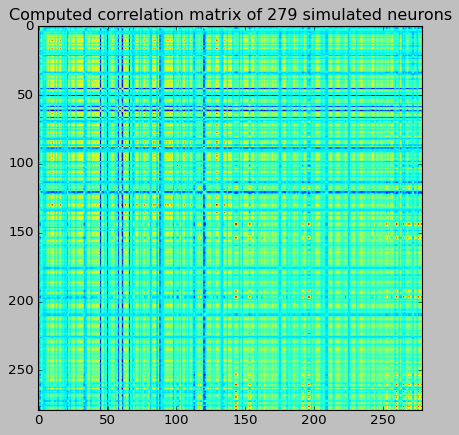

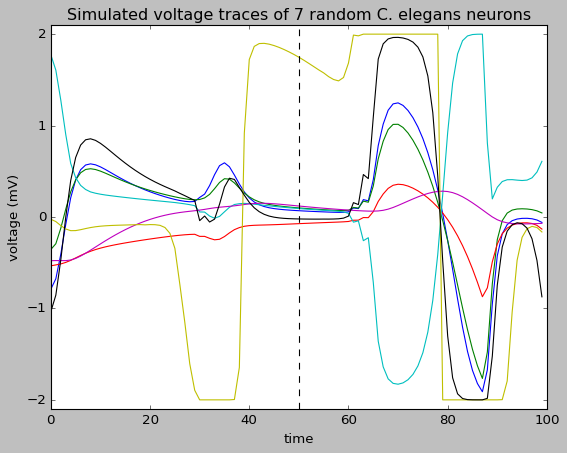

In [565]:
#@title Plots from the simulated data.

mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color='bgrcmyk')

plt.figure()
plt.imshow(simul_data.T @ simul_data)
plt.title('Computed correlation matrix of %s simulated neurons'%N)
plt.show()

inds = np.random.choice(range(N), 7)
plt.figure()
plt.plot(simul_data[:, inds])
plt.axvline(x=int(1/2 * simul_data.shape[0]), c='k', linestyle='--')
plt.xlabel('time')
plt.ylabel('voltage (mV)')
plt.title('Simulated voltage traces of %s random C. elegans neurons'%len(inds))
plt.ylim([-2.1, 2.1])
plt.show()

## Real (experimental) data.

In [566]:
#@title Let's load some real C. elegans data now!
#@markdown First let's get the `.mat` file from GDrive.
#@markdown The calcium activity data is in `Ratio2`

arr = loadmat('heatData_worm1.mat')
print(list(arr.keys())[3:])
print()

Ratio2 = arr['Ratio2'] # the ratio signal is defined as gPhotoCorr/rPhotoCorr, the Ratio is then normalized as delta R/ R0. is the same way as R2 and G2.
acorr = arr['acorr'] # a n Neurons x n Neurons pearson correlation matrix of Ratio2
cgIdx = arr['cgIdx'].squeeze() # ordered indices derived from heirarchically clustering the correlation matrix. 

real_data = Ratio2[cgIdx-1, :].T # to show organized traces, use Ratio2(cgIdx,:)
real_data = np.nan_to_num(real_data) # replace NaNs 
L, N = real_data.shape # num_timesteps x n_neuron
print('\nnum. neurons %s, length of recording %s'%(N,L))

['hasPointsTime', 'ethoTrack', 'R2', 'G2', 'Ratio2', 'acorr', 'cgIdx', 'cgIdxRev', 'rRaw', 'gRaw', 'rPhotoCorr', 'gPhotoCorr']


num. neurons 156, length of recording 2849


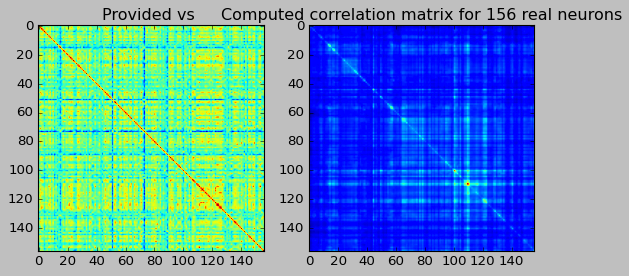

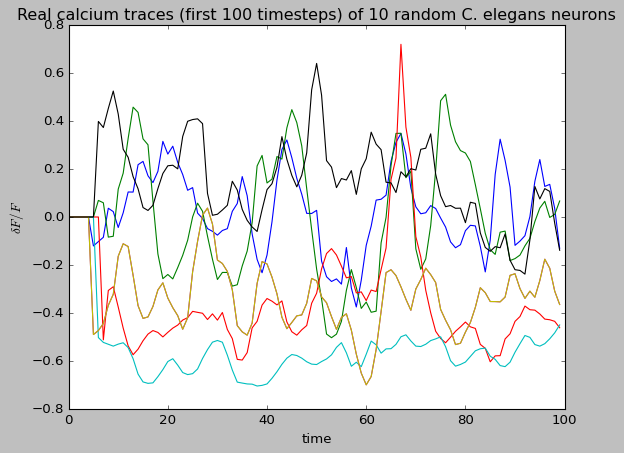

In [567]:
#@title Some figures made from the real data.

mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color='bgrcmyk')

fig, axs = plt.subplots(1,2)
axs[0].imshow(acorr)
axs[0].set_title('Provided vs ')
axs[1].imshow(real_data.T @ real_data)
axs[1].set_title('Computed correlation matrix for %s real neurons'%N)
plt.show()

plt.figure()
inds = np.random.choice(range(N), 7)
plt.plot(real_data[:100, inds])
plt.xlabel('time')
plt.ylabel('$\delta F / F$')
plt.title('Real calcium traces (first 100 timesteps) of 10 random C. elegans neurons')
plt.show()

## Training a simple LSTM model.

**Task:** 1-step ahead prediction.

We want to predict on the last half of the voltage time-series by training on the first half.

To-Do: Make a data loader function and training regime that will work for arbitrary *n*-timestep ahead predictions given arbitray history lengths.

In [568]:
#@title Choose dataset (simulated or real) to use for training.

data = real_data
# data = simul_data
sc = preprocessing.MinMaxScaler()
data = sc.fit_transform(data[:100, :N]) # num_timesteps x n_neurons
print("shape of the data", data.shape)

shape of the data (100, 156)


In [569]:
#@title Data loading.
#@markdown TODO: use Pytorch dataloaders to do this.

def sliding_windows(data, seq_length):
    '''Function for creating 1-timestep ahead 
    prediction datasets.'''
    x = []
    y = []
    num_batches = len(data)-seq_length-1
    for i in range(num_batches): # determines number of batches
        _x = data[i:(i+seq_length)]
        _y = data[i+seq_length] # next time-step
        x.append(_x)
        y.append(_y)
    return np.array(x), np.array(y)

seq_length = 9 # length of sliding window
x, y = sliding_windows(data=data, seq_length=seq_length)
num_batches = len(y)
print('Num. batches', num_batches)

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

Num. batches 90


In [570]:
#@title Using a custom-made data loader.

train_size = int(num_batches * 0.5)
test_size = num_batches - train_size

# shuffle = np.arange(num_batches) # shuffle indices
# np.random.shuffle(shuffle)
# train_inds, test_inds = np.split(shuffle, 2)

trainX = dataX[0:train_size]
trainY = dataY[0:train_size]

testX = dataX[train_size:len(x)]
testY = dataY[train_size:len(y)]

print(trainX.shape) # batch_size, sequence_length, input_size
print(trainY.shape)

torch.Size([45, 9, 156])
torch.Size([45, 156])


In [571]:
#@title Better: Using Pytorch's `DataLoader`.
#@markdown We first must define a Pytorch Dataset class.

class Dataset(torch.utils.data.Dataset):
  'Characterizes a dataset for PyTorch.'
  def __init__(self, data, labels):
        'Initialization'
        self.data = data
        self.labels = labels

  def __len__(self):
        'Denotes the total number of samples'
        return len(self.labels)

  def __getitem__(self, index):
        'Generates one sample of data'
        # Load data and get label
        X = self.data[index]
        y = self.labels[index]

        return X, y

dataset = Dataset(dataX, dataY)
print('Num. samples', len(dataset))

train_split = 0.5
train_inds = range(0, int(train_split*len(x)))
test_inds = range(int(train_split*len(x)), len(x))

train_dataset = Dataset(dataX[train_inds], dataY[train_inds])
test_dataset = Dataset(dataX[test_inds], dataY[test_inds])

train_loader = D.DataLoader(train_dataset, 
                            batch_size=15, shuffle=False)
test_loader = D.DataLoader(test_dataset, 
                           batch_size=15, shuffle=False)

batch = next(iter(train_loader))
print('Batch #1', batch[0].shape, batch[1].shape) # batch.data, batch.labels
# print(batch.shape)

Num. samples 90
Batch #1 torch.Size([15, 9, 156]) torch.Size([15, 156])


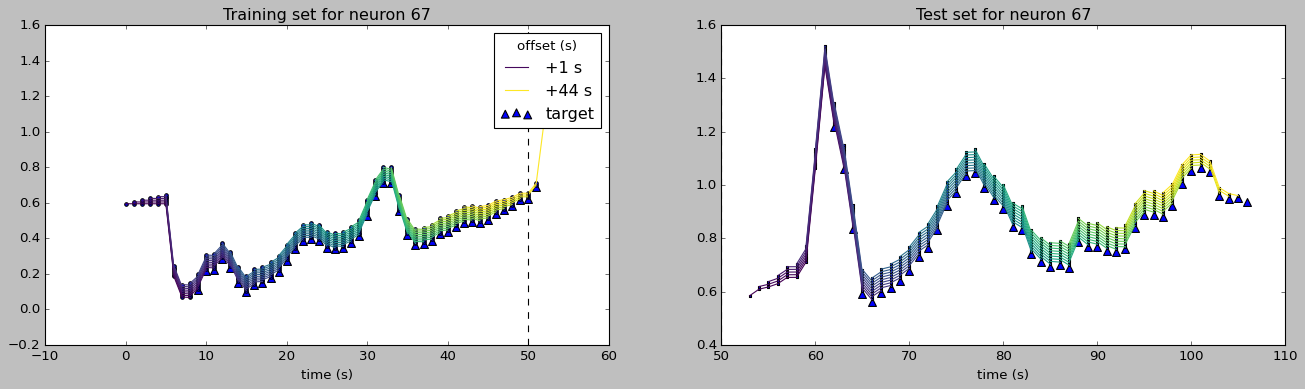

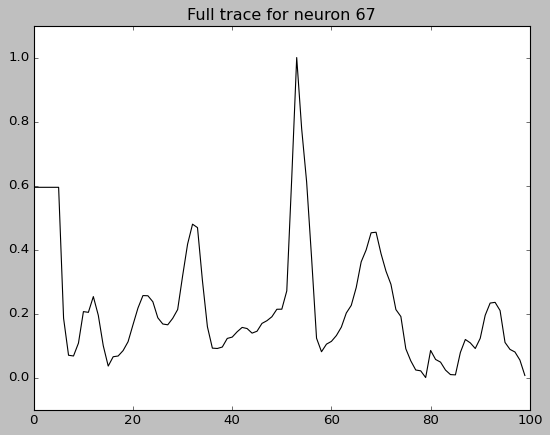

In [572]:
#@title Visualize train and test sets for single neuron 1-step ahead prediction.
eps = np.arange(num_batches)/100
idx = np.random.choice(range(N)) # pick a random neuron

mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color='bgrcmyk')
color = plt.cm.viridis(np.linspace(0, 1, trainX.shape[0]))
mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=color) 

fig, axs = plt.subplots(1,2, figsize=(20,5))
for i in range(trainX.shape[0]):  
  if i==1 or i==trainX.shape[0]-1:
    label = '+%s s'%i
  else: 
    label=None
  axs[0].plot(range(i, trainX.shape[1]+i), eps[i] + trainX[i, :, idx], label=label);
  axs[0].scatter(range(i, trainX.shape[1]+i),  eps[i] + trainX[i, :, idx], s=10);
  axs[0].scatter(trainX.shape[1]+i,  eps[i] + trainY[i, idx], marker='^', s=50, 
                 label='target' if i==0 else None);

axs[0].legend(title='offset (s)')
axs[0].axvline(x=int(1/2 * data.shape[0]), c='k', linestyle='--')
axs[0].set_xlabel('time (s)')
axs[0].set_title('Training set for neuron %s'%idx);

plt.gca().set_prop_cycle(None)

for j in range(testX.shape[0]):
  axs[1].plot(range(trainX.shape[1] + i + j, trainX.shape[1] + testX.shape[1] + i + j), 
              eps[i] + eps[j] + testX[j, :, idx], '-', label='+%s s'%j);
  axs[1].scatter(range(trainX.shape[1] + i + j, trainX.shape[1] + testX.shape[1] + i + j),  
                 eps[i] + eps[j] + testX[j, :, idx], marker='s', s=5);
  axs[1].scatter(2*trainX.shape[1] + i + j,  eps[i] + eps[j] + testY[j, idx], marker='^', s=50);

# TODO: fix so that axes correspond
axs[1].set_xlabel('time (s)')
axs[1].axvline(x=int(1/2 * data.shape[0]), c='k', linestyle='--')
axs[1].set_title('Test set for neuron %s'%idx);
plt.show()

plt.figure()
plt.plot(data[:, idx], c='k')
plt.ylim([-0.1,1.1])
plt.title('Full trace for neuron %s'%idx)
plt.show()

In [573]:
#@title Model (LSTM)

class LSTM(nn.Module):

    def __init__(self, num_classes, input_size, seq_length, hidden_size, num_layers):
        super(LSTM, self).__init__()
        
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.seq_length = seq_length
        
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True, bias=True)
        
        # self.fc = nn.Linear(hidden_size, num_classes)
        self.fc = nn.Linear(self.seq_length*self.hidden_size, num_classes) # more powerful decoder

    def forward(self, x, state=None):
        # Propagate input through LSTM
        lstm_out, state = self.lstm(x, state) # shape (N, L, H_out)
        lstm_out = lstm_out.contiguous().view(-1, self.seq_length*self.hidden_size)
        fc_out = self.fc(lstm_out) # more powerful decoder

        # h_out, c_out = state # shape (N, H_out), N = batch_size
        # h_out = h_out.view(-1, self.hidden_size)
        # fc_out = self.fc(h_out) # weaker decoder
  
        return fc_out, state

In [574]:
#@title Training the model and experimenting with parameters.
#@markdown This is NOT an autoregressive model.<br> 
#@markdown Instead, the model is trained to make 1-step predictions given a 
#@markdown history window of length 9.

# define a training function
def train(trainX, trainY):
  # setup
  global model, optimizer, criterion, num_epochs
  model.train()
  losses = []
  epochs = []
  # training loop
  for epoch in range(num_epochs+1):
      optimizer.zero_grad()
      # forward pass
      if epoch == 0:
        outputs, states = model(trainX)
      else: # feed previous hidden states forward
        states = tuple(map(lambda x: x.detach(), states))
        outputs, states = model(trainX, states)
      # calculate the loss 
      loss = criterion(outputs, trainY)
      # backward bass
      loss.backward()
      # gradient descent
      optimizer.step()
      # printing and saving
      if epoch % 100 == 0:
        print("Epoch: %d, Train Loss: %1.5f" % (epoch, loss.item()))
        epochs.append(epoch)
        losses.append(loss.detach().cpu().item())
  # return losses
  return losses, epochs

# hyper-parameters
num_epochs = 1000
learning_rate = 0.01
input_size = N
seq_length = seq_length
num_layers = 1 # simple, one hidden-layer LSTM
num_classes = N

# we experiment with different hidden sizes
hidden_experiment = dict()
for hidden_size in [8, 16, 32, 64, 128, N//2, N]:
  print()
  print("Hidden size: %d" % hidden_size)
  print("~~~~~~~~~~~~~~~")
  # initialization
  model = LSTM(num_classes, input_size, seq_length, hidden_size, num_layers)
  optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
  criterion = torch.nn.MSELoss() # mean-squared error for regression
  # train the model
  losses, epochs = train(trainX, trainY)
  # log results of this experiment      
  hidden_experiment[hidden_size] = losses


Hidden size: 8
~~~~~~~~~~~~~~~
Epoch: 0, Train Loss: 0.22521
Epoch: 100, Train Loss: 0.00663
Epoch: 200, Train Loss: 0.00172
Epoch: 300, Train Loss: 0.00079
Epoch: 400, Train Loss: 0.00054
Epoch: 500, Train Loss: 0.00043
Epoch: 600, Train Loss: 0.00046
Epoch: 700, Train Loss: 0.00031
Epoch: 800, Train Loss: 0.00035
Epoch: 900, Train Loss: 0.00023
Epoch: 1000, Train Loss: 0.00021

Hidden size: 16
~~~~~~~~~~~~~~~
Epoch: 0, Train Loss: 0.21506
Epoch: 100, Train Loss: 0.00416
Epoch: 200, Train Loss: 0.00092
Epoch: 300, Train Loss: 0.00058
Epoch: 400, Train Loss: 0.00043
Epoch: 500, Train Loss: 0.00034
Epoch: 600, Train Loss: 0.00027
Epoch: 700, Train Loss: 0.00037
Epoch: 800, Train Loss: 0.00017
Epoch: 900, Train Loss: 0.00086
Epoch: 1000, Train Loss: 0.00009

Hidden size: 32
~~~~~~~~~~~~~~~
Epoch: 0, Train Loss: 0.21394
Epoch: 100, Train Loss: 0.00449
Epoch: 200, Train Loss: 0.00110
Epoch: 300, Train Loss: 0.00062
Epoch: 400, Train Loss: 0.00045
Epoch: 500, Train Loss: 0.00032
Epoch: 600

In [575]:
# @title This is a more Pytorch style train and test pipeline.

# # hyper-parameters
# num_epochs = 1000
# learning_rate = 0.01
# input_size = N
# seq_length = seq_length
# num_layers = 1 # simple, one hidden-layer LSTM
# num_classes = N

# def train(loader):
#     model.train()
#     train_loss = 0
#     for i, data in enumerate(loader): # Iterate in batches over the training dataset.
#         X, y  = data
#         X = X.to(device) # Put data on GPU.
#         # Perform a single forward pass.
#         try:
#           out, states = model(X, states)
#         except:
#           out, states = model(X)
#         states = tuple(map(lambda x: x.detach(), states))
        
#         loss = criterion(out, y)  # Compute the training loss.
#         loss.backward()  # Derive gradients.
#         optimizer.step()  # Update parameters based on gradients.
#         optimizer.zero_grad()  # Clear gradients.
#         train_loss += loss.detach().item()
#     return train_loss

# def test(loader):
#      model.eval()
#      val_loss = 0
#      for i, data in enumerate(loader): # Iterate in batches over the training/test dataset.
#          X, y  = data
#          X = X.to(device) # Put data on GPU.
#          # Perform a single forward pass.
#          try:
#            out, states = model(X, states)
#          except:
#            out, states = model(X)
#          states = tuple(map(lambda x: x.detach(), states))
         
#          val_loss += criterion(out, y)  # Compute the validation loss.
#      return val_loss  # Return the mean validation loss.

# # we experiment with different hidden sizes
# hidden_experiment = dict()
# for hidden_size in [8, 16, 32, 64, 128, N//2, N]:
#   print()
#   print("Hidden size: %d" % hidden_size)
#   print("~~~~~~~~~~~~~~~")
#   # initialize model, optimizer and loss function
#   model = LSTM(num_classes, input_size, seq_length, hidden_size, num_layers)
#   optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
#   criterion = torch.nn.MSELoss() # mean-squared error for regression
#   # iterate over the training data multiple times
#   losses, epochs = [], []
#   for epoch in range(num_epochs+1):
#       # train the model
#       train_loss = train(train_loader)
#       test_loss = test(test_loader)
#       if epoch % 100 == 0:
#         print(f'Epoch: {epoch:03d}, Train Loss: {train_loss:.4f}, Val. Loss: {test_loss:.4f}')
#         epochs.append(epoch)
#         losses.append(train_loss)
#   # log results of this experiment      
#   hidden_experiment[hidden_size] = losses

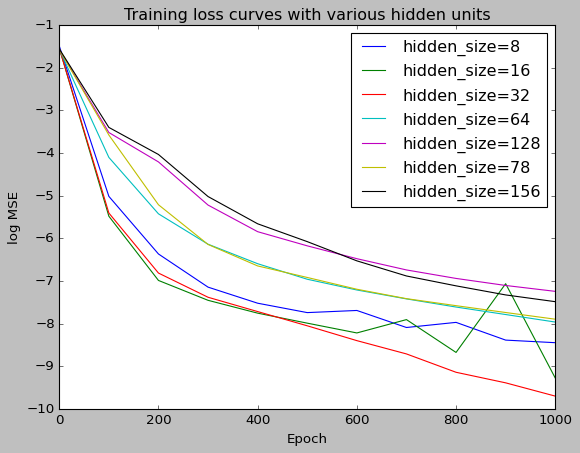

In [576]:
#@title Loss curves for various values of `hidden_size`.
#@markdown **TO-DO**: Also plot loss on the test-set.

mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color='bgrcmyk')

plt.figure()
for hs in hidden_experiment:
  plt.plot(epochs, np.log(hidden_experiment[hs]), label='hidden_size=%d'%hs)
  plt.xlabel('Epoch')
  plt.ylabel('log MSE')
plt.legend()
plt.title('Training loss curves with various hidden units')
plt.show()

For simulated data, the prediction performace on average improves with more hidden units. The inverse happens with real experimental data: more (hidden units) is not better!

In [577]:
#@title Make predictions on the full dataset.

model.eval()
train_predict, _ = model(dataX)
data_predict = train_predict.data.numpy()
dataY_plot = dataY.data.numpy()

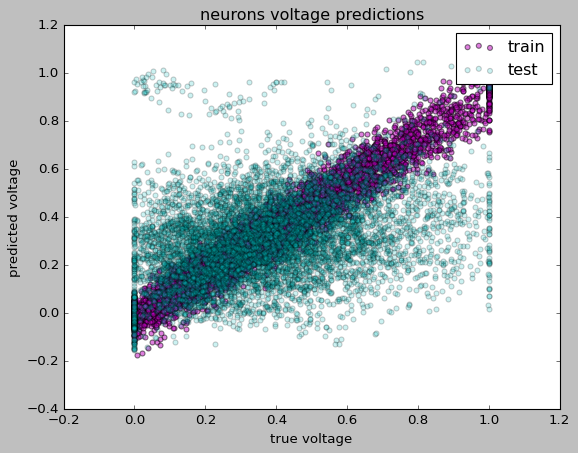

In [578]:
#@title Correlation between predicted and true voltage.

mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color='bgrcmyk')

plt.figure()
plt.scatter(dataY_plot[0:train_size], data_predict[0:train_size], c='m', 
            alpha=0.5, label='train')
plt.scatter(dataY_plot[train_size:], data_predict[train_size:], c='c', 
            alpha=0.2, label='test')
plt.title('neurons voltage predictions')
plt.xlabel('true voltage')
plt.ylabel('predicted voltage')
plt.legend()
plt.show()

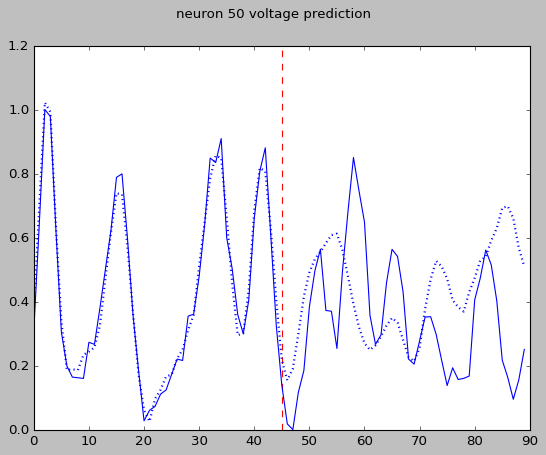

In [579]:
#@title Voltage prediction for a single neuron.

neuron_id = np.random.choice(N) # pick a random neuron to predict

plt.figure()
plt.axvline(x=train_size, c='r', linestyle='--')
plt.plot(dataY_plot[:, neuron_id])
plt.gca().set_prop_cycle(None)
plt.plot(data_predict[:, neuron_id], ':', linewidth=2)
plt.suptitle('neuron {} voltage prediction'.format(neuron_id))
plt.show()

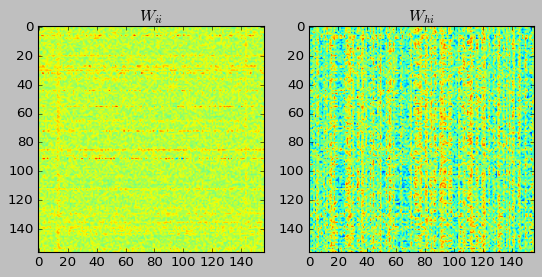

In [580]:
#@title LSTM weight matrices.
#@markdown We plot figures of the trained RNN model weights. 

W_ii, W_if, W_ig, W_io = np.split(model.lstm.weight_ih_l0.detach(), 4)
W_hi, W_hf, W_hg, W_ho = np.split(model.lstm.weight_hh_l0.detach(), 4)

fig, axs = plt.subplots(1,2)
axs[0].imshow(W_ii)
axs[0].set_title('$W_{ii}$')
axs[1].imshow(W_hi)
axs[1].set_title('$W_{hi}$')
plt.show()

Now we constrain the RNN's connectivity by the *C. elegans* connectome.

To-Do: set a mask on the LSTM weights

# Constructing the *C. elegans* connectome graph.

In [581]:
#@title Load hermaphrodite connectivity graphs
#@markdown Get the connevtivity matrices `.mat` files from GDrive.

GHermChem = loadmat('GHermChem.mat')
GHermElec_Sym = loadmat('GHermElec_Sym.mat')

print(GHermChem.keys())
print(); print()
print(GHermElec_Sym.keys())

dict_keys(['__header__', '__version__', '__globals__', 'AHermChem', 'BodyWallMuscles', 'None', 'InterNeurons', 'InterNeurons_0', 'InterNeurons_1', 'InterNeurons_2', 'InterNeurons_3', 'InterNeurons_4', 'IsolatedNeurons', 'MotorNeurons', 'MotorNeurons_Body', 'MotorNeurons_Head', 'MotorNeurons_Sublateral', 'OtherEndOrgans', 'Pharynx', 'SensoryNeurons', 'SensoryNeurons_1', 'SensoryNeurons_2', 'SensoryNeurons_3', 'SensoryNeurons_4', 'SensoryNeurons_5', 'SensoryNeurons_6', 'SexSpecificCells', '__function_workspace__'])


dict_keys(['__header__', '__version__', '__globals__', 'AHermElec_Sym', 'BodyWallMuscles', 'None', 'InterNeurons', 'InterNeurons_0', 'InterNeurons_1', 'InterNeurons_2', 'InterNeurons_3', 'InterNeurons_4', 'MotorNeurons', 'MotorNeurons_Head', 'MotorNeurons_Sublateral', 'MotorNeurons_VentralCord', 'OtherEndOrgans', 'Pharynx', 'SensoryNeurons', 'SensoryNeurons_1', 'SensoryNeurons_2', 'SensoryNeurons_3', 'SensoryNeurons_4', 'SensoryNeurons_5', 'SensoryNeurons_6', 'SexSpecificCel

The `*.mat` files contains the data corresponding to one connectome. To be specific, each `*.mat` has the following information:
 -  A. Digraph (in case of a chemical connectome, e.g., GHermChem) or undirected graph (in case of a gap junction symmetric connectome, e.g., GHermElec_Sym). ***NOT AVAILABLE in Python.***
 -  B. Adjacency matrix (e.g., AHermChem or AHermChem_Sym). Its (i, j)-th element is the edge
weight from node i to node j.
 - C. Neuron names in each group. e.g., InterNeurons contains all the neurons that belong to the
“InterNeurons” group.
 - D. Neuron names in each subgroup, e.g., InterNeurons_0 contains all the neurons that belong to
the “InterNeurons_0” subgroup of the “InterNeurons” group.


Beacause what we really need is A. and it is not accesible from the `*.mat` file, we instead load exported Edges and Nodes tables for each type of synapse (chemical vs electrical).

In [582]:
# @title Chemical synapses graph

GHermChem_Edges = pd.read_csv('GHermChem_Edges.csv') # edges
GHermChem_Nodes =  pd.read_csv('GHermChem_Nodes.csv') # nodes
GHermChem_Edges

,EndNodes_1,EndNodes_2,Weight
0,I2L,I1L,2
1,I2L,I5,2
2,I2L,I2R,3
3,I2L,I6,2
4,I2L,M1,1
...,...,...,...
4874,VD10,vBWML19,4
4875,VD10,vBWML20,4
4876,VD10,vBWMR19,4
4877,VD10,vBWMR20,4


In [583]:
# @title Gap junctions graph

GHermElec_Sym_Edges = pd.read_csv('GHermElec_Sym_Edges.csv') # edges
GHermElec_Sym_Nodes =  pd.read_csv('GHermElec_Sym_Nodes.csv') # nodes
GHermElec_Sym_Nodes

,Name,Group,Subgroup
0,I2L,Pharynx,NaN
1,I1L,Pharynx,NaN
2,M3L,Pharynx,NaN
3,MCR,Pharynx,NaN
4,NSML,Pharynx,NaN
...,...,...,...
464,AS08,MotorNeurons,MotorNeurons_VentralCord
465,AS09,MotorNeurons,MotorNeurons_VentralCord
466,CEPshDL,OtherEndOrgans,NaN
467,CEPshDR,OtherEndOrgans,NaN


In [584]:
#@title Extract neuron only nodes

# neurons involved in gap junctions
df = GHermElec_Sym_Nodes
Ggap_nodes = df[df['Group'].str.contains("Neuron")].sort_values(by=['Name']).reset_index()

# neurons involved in chemical synapses
df = GHermChem_Nodes
Gsyn_nodes = df[df['Group'].str.contains("Neuron")].sort_values(by=['Name']).reset_index()

print('gap-junction neurons\n', Ggap_nodes.Name)
print()
print('synapse neurons\n', Gsyn_nodes.Name)

gap-junction neurons
 0      ADAL
1      ADAR
2      ADEL
3      ADER
4      ADFL
       ... 
267    VD09
268    VD10
269    VD11
270    VD12
271    VD13
Name: Name, Length: 272, dtype: object

synapse neurons
 0      ADAL
1      ADAR
2      ADEL
3      ADER
4      ADFL
       ... 
267    VD09
268    VD10
269    VD11
270    VD12
271    VD13
Name: Name, Length: 272, dtype: object


In [585]:
#@title Extract neuron only edges

# gap junctions
df = GHermElec_Sym_Edges
inds = [i for i in GHermElec_Sym_Edges.index if 
        df.iloc[i]['EndNodes_1'] in set(Ggap_nodes.Name) and 
        df.iloc[i]['EndNodes_2'] in set(Ggap_nodes.Name)] # indices
Ggap_edges = df.iloc[inds].reset_index(drop=True)

# chemical synapses
df = GHermChem_Edges
inds = [i for i in GHermChem_Edges.index if 
        df.iloc[i]['EndNodes_1'] in set(Gsyn_nodes.Name) and 
        df.iloc[i]['EndNodes_2'] in set(Gsyn_nodes.Name)] # indices
Gsyn_edges = df.iloc[inds].reset_index(drop=True)

print('gap junctions\n', Ggap_edges)
print()
print('chemical synapses\n', Gsyn_edges)

gap junctions
      EndNodes_1 EndNodes_2  Weight
0          RIPL       RIPL       4
1          RIPL       RIPR       2
2          RIPL       ADFL       2
3          RIPL       RMED       2
4          RIPL      URAVL       1
...         ...        ...     ...
1022       DD04       VD07       1
1023       DD04       DD05       3
1024       DD04       VD08       2
1025       VD07       VD08       6
1026       DD05       VD10       2

[1027 rows x 3 columns]

chemical synapses
      EndNodes_1 EndNodes_2  Weight
0          RIPL       RIPL       3
1          RIPL       ADFL       3
2          RIPL       BAGL       7
3          RIPL        RIH       2
4          RIPL       OLLL       4
...         ...        ...     ...
3385       VD04       VB03       2
3386       VD09       VA09       3
3387       VD09       VB08       2
3388       VD10       VA10       2
3389       VD10       VB09       1

[3390 rows x 3 columns]


***Data Handling of Graphs***

A graph is used to model pairwise relations (edges) between objects (nodes). A single graph in PyG is described by an instance of `torch_geometric.data.Data`, which holds the following attributes by default:

`data.x`: Node feature matrix with shape `[num_nodes, num_node_features]`

`data.edge_index`: Graph connectivity in COO format with shape `[2, num_edges]` and type `torch.long`

`data.edge_attr`: Edge feature matrix with shape `[num_edges, num_edge_features]`

`data.y`: Target to train against (may have arbitrary shape), e.g., node-level targets of shape `[num_nodes, *]` or graph-level targets of shape `[1, *]`

`data.pos`: Node position matrix with shape `[num_nodes, num_dimensions]`



In [586]:
#@title Map neuron names (IDs) to indices

neuron_id  = dict(zip(Gsyn_nodes.Name.values, Gsyn_nodes.index.values))
id_neuron = dict(zip(Gsyn_nodes.index.values, Gsyn_nodes.Name.values))
print(id_neuron)

{0: 'ADAL', 1: 'ADAR', 2: 'ADEL', 3: 'ADER', 4: 'ADFL', 5: 'ADFR', 6: 'ADLL', 7: 'ADLR', 8: 'AFDL', 9: 'AFDR', 10: 'AIAL', 11: 'AIAR', 12: 'AIBL', 13: 'AIBR', 14: 'AIML', 15: 'AIMR', 16: 'AINL', 17: 'AINR', 18: 'AIYL', 19: 'AIYR', 20: 'AIZL', 21: 'AIZR', 22: 'ALA', 23: 'ALML', 24: 'ALMR', 25: 'ALNL', 26: 'ALNR', 27: 'AQR', 28: 'AS01', 29: 'AS02', 30: 'AS03', 31: 'AS04', 32: 'AS05', 33: 'AS06', 34: 'AS07', 35: 'AS08', 36: 'AS09', 37: 'AS10', 38: 'AS11', 39: 'ASEL', 40: 'ASER', 41: 'ASGL', 42: 'ASGR', 43: 'ASHL', 44: 'ASHR', 45: 'ASIL', 46: 'ASIR', 47: 'ASJL', 48: 'ASJR', 49: 'ASKL', 50: 'ASKR', 51: 'AUAL', 52: 'AUAR', 53: 'AVAL', 54: 'AVAR', 55: 'AVBL', 56: 'AVBR', 57: 'AVDL', 58: 'AVDR', 59: 'AVEL', 60: 'AVER', 61: 'AVFL', 62: 'AVFR', 63: 'AVG', 64: 'AVHL', 65: 'AVHR', 66: 'AVJL', 67: 'AVJR', 68: 'AVKL', 69: 'AVKR', 70: 'AVL', 71: 'AVM', 72: 'AWAL', 73: 'AWAR', 74: 'AWBL', 75: 'AWBR', 76: 'AWCL', 77: 'AWCR', 78: 'BAGL', 79: 'BAGR', 80: 'BDUL', 81: 'BDUR', 82: 'CEPDL', 83: 'CEPDR', 84: 

In [587]:
#@title Get `edge_index`: graph connectivity in COO format

# for gap junctions
arr = Ggap_edges[['EndNodes_1', 'EndNodes_2']].values
ggap_edge_index = torch.empty(*arr.shape, dtype=torch.long) 
for i, row in enumerate(arr):
  ggap_edge_index[i,:] = torch.tensor([neuron_id[x] for x in row], 
                                      dtype=torch.long)
ggap_edge_index = ggap_edge_index.T # [2, num_edges]

# for chemical synapses
arr = Gsyn_edges[['EndNodes_1', 'EndNodes_2']].values
gsyn_edge_index = torch.empty(*arr.shape, dtype=torch.long) 
for i, row in enumerate(arr):
  gsyn_edge_index[i,:] = torch.tensor([neuron_id[x] for x in row], 
                                      dtype=torch.long)
gsyn_edge_index = gsyn_edge_index.T # [2, num_edges]

print('gap junctions\n', ggap_edge_index, ggap_edge_index.shape)
print()
print('chemical synapses\n', gsyn_edge_index, gsyn_edge_index.shape)

gap junctions
 tensor([[177, 177, 177,  ..., 105, 265, 106],
        [177, 178,   4,  ..., 266, 266, 268]]) torch.Size([2, 1027])

chemical synapses
 tensor([[177, 177, 177,  ..., 267, 268, 268],
        [177,   4,  78,  ..., 255, 245, 256]]) torch.Size([2, 3390])


In [588]:
#@title Get `edge_attr`: edge feature matrix
#@markdown We use two edge features: the first is for the weighted gap junction
#@markdown synapse, and the second for the weighted chemical synapse. 

num_edge_features = 2

# for gap junctions
num_edges = len(Ggap_edges)
ggap_edge_attr = torch.empty(num_edges, num_edge_features, 
                             dtype=torch.float) # [num_edges, num_edge_features]
for i, weight in enumerate(Ggap_edges.Weight.values):
  ggap_edge_attr[i,:] = torch.tensor([weight, 0], 
                                     dtype=torch.float) # electrical synapse encoded as [1,0]

# for chemical synapses
num_edges = len(Gsyn_edges)
gsyn_edge_attr = torch.empty(num_edges, num_edge_features, 
                             dtype=torch.float) # [num_edges, num_edge_features]
for i, weight in enumerate(Gsyn_edges.Weight.values):
  gsyn_edge_attr[i,:] = torch.tensor([0, weight], 
                                     dtype=torch.float) # chemical synapse encoded as [0,1]

print('gap junctions\n', ggap_edge_attr, ggap_edge_attr.shape)
print()
print('chemical synapses\n', gsyn_edge_attr, gsyn_edge_attr.shape)

gap junctions
 tensor([[4., 0.],
        [2., 0.],
        [2., 0.],
        ...,
        [2., 0.],
        [6., 0.],
        [2., 0.]]) torch.Size([1027, 2])

chemical synapses
 tensor([[0., 3.],
        [0., 3.],
        [0., 7.],
        ...,
        [0., 2.],
        [0., 2.],
        [0., 1.]]) torch.Size([3390, 2])


In [589]:
#@title Get `data.x`: node feature matrix
#@markdown Eventually, we want the each node's features to be the full time series of it's
#@markdown activity over a recording of `T` timsteps, where `T=num_node_features`.
#@markdown Since we don't have real data now, we will just generate some random data.
#@markdown Perhaps we can use the Leifer functinal connectivity data (from https://funconn.princeton.edu/)
#@markdown here instead of random data

num_nodes = len(Gsyn_nodes)
num_node_features = 1024

# generate random data
x = torch.rand(num_nodes, num_node_features, dtype=torch.float) # [num_nodes, num_node_features]

In [590]:
#@title Get `data.y`: target to train against
#@markdown May have arbitrary shape, 
#@markdown e.g., node-level targets of shape `[num_nodes, *]`
#@markdown or graph-level targets of shape `[1, *]`

le = preprocessing.LabelEncoder()
le.fit(Gsyn_nodes.Group.values)

y = torch.tensor(le.transform(Gsyn_nodes.Group.values), 
                 dtype=torch.float) # [num_nodes, 1]

In [591]:
#@title Finally, create a separate graph for electrical connectivity and chemical connectivity

# for electrical connectivity
electrical_graph = Data(x=x, edge_index=ggap_edge_index, edge_attr=ggap_edge_attr, y=y)

# for chemical connectivity
chemical_graph = Data(x=x, edge_index=gsyn_edge_index, edge_attr=gsyn_edge_attr, y=y)

print('Gap junction graph', electrical_graph)
print()
print('Chemical synapse graph', chemical_graph)
print()

Gap junction graph Data(x=[272, 1024], edge_index=[2, 1027], edge_attr=[1027, 2], y=[272])

Chemical synapse graph Data(x=[272, 1024], edge_index=[2, 3390], edge_attr=[3390, 2], y=[272])



In [592]:
#@title Batching the two graphs does not give the desired connection.

data_list = [electrical_graph, chemical_graph]
loader = DataLoader(data_list, batch_size=2)

batch = next(iter(loader))
batch

DataBatch(x=[544, 1024], edge_index=[2, 4417], edge_attr=[4417, 2], y=[544], batch=[544], ptr=[3])

In [593]:
#@title We need to merge the electrical and chemical graphs into a single connectome graph.
#@markdown We confirm the shape of the connectome graph is correct by comparing its
#@markdown dimensions to that from batching the separate graphs. Notice that the
#@markdown the number of edges is smaller (`4034 < 4417`) because neuron pairs
#@markdown with both gap juctions and electrical synapses have been summed. 

edge_index = torch.hstack((electrical_graph.edge_index, chemical_graph.edge_index)) # features = [elecjunc_wt, chemsyn_wt]
edge_attr = torch.vstack((electrical_graph.edge_attr, chemical_graph.edge_attr)) 
edge_index, edge_attr = torch_geometric.utils.coalesce(edge_index, edge_attr, reduce="add")

assert all(chemical_graph.y == electrical_graph.y), "Node labels not matched!"
x = chemical_graph.x 
y = chemical_graph.y

graph = Data(x=x, edge_index=edge_index, edge_attr=edge_attr, y=y)
graph

Data(x=[272, 1024], edge_index=[2, 4034], edge_attr=[4034, 2], y=[272])

In [594]:
#@title Investigate the C. elegans graph.

print("Attributes:", "\n", graph.keys, "\n",
      f"Num. nodes {graph.num_nodes}, Num. edges {graph.num_edges}, " 
      f"Num. node features {graph.num_node_features}", end="\n")
print(f"\tHas isolated nodes: {graph.has_isolated_nodes()}")
print(f"\tHas self-loops: {graph.has_self_loops()}")
print(f"\tIs undirected: {graph.is_undirected()}")
print(f"\tIs directed: {graph.is_directed()}") 

Attributes: 
 ['edge_attr', 'edge_index', 'y', 'x'] 
 Num. nodes 272, Num. edges 4034, Num. node features 1024
	Has isolated nodes: False
	Has self-loops: True
	Is undirected: False
	Is directed: True


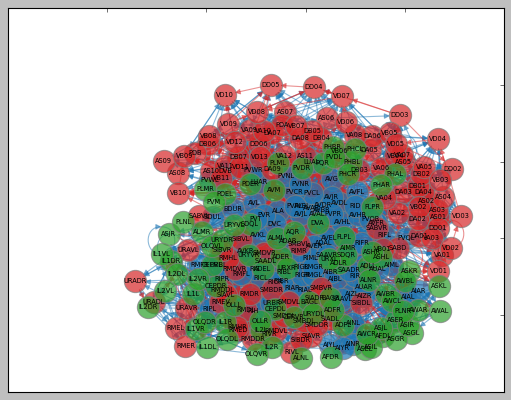

In [595]:
#@title Draw the graph of the C. elegans connectome

G = torch_geometric.utils.to_networkx(graph)
pos = nx.kamada_kawai_layout(G) # BEST
# pos = nx.random_layout(G) 
# pos = nx.shell_layout(G) 
# pos = nx.spectral_layout(G) 
# pos = nx.spiral_layout(G) 
# pos = nx.spring_layout(G) 

options = {"edgecolors": "tab:gray", "node_size": 400, "alpha": 0.7}
sensory = [node for i,node in enumerate(G.nodes) if graph.y[i]==0.]
inter = [node for i,node in enumerate(G.nodes) if graph.y[i]==1.]
motor = [node for i,node in enumerate(G.nodes) if graph.y[i]==2.]

nx.draw_networkx_nodes(G, pos, nodelist=sensory, node_color="tab:blue", **options);
nx.draw_networkx_nodes(G, pos, nodelist=inter, node_color="tab:red", **options);
nx.draw_networkx_nodes(G, pos, nodelist=motor, node_color="tab:green", **options);

labels = id_neuron
nx.draw_networkx_labels(G, pos, labels, font_size=6);

junctions = [edge for i,edge in enumerate(G.edges) if graph.edge_attr[i,0]==0.]
synapses = [edge for i,edge in enumerate(G.edges) if graph.edge_attr[i,1]==0.]

nx.draw_networkx_edges(G, pos, edgelist=junctions, alpha=0.5, edge_color="tab:blue");
nx.draw_networkx_edges(G, pos, edgelist=synapses, alpha=0.5, edge_color="tab:red");

We have a neuron atlas in the file `LowResAtlasWithHighResHeadsAndTails.csv` with neuron names mapped to 3D coordinates. Load this data and use the first two coordinates (2D) from it for the `pos` argument to `nx.draw_networkx`. 

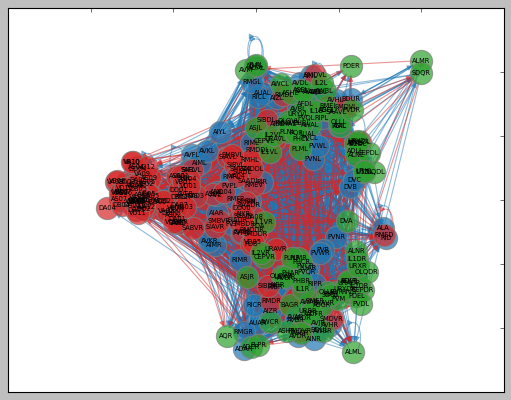

In [596]:
#@title Draw using atlas coordinates.

neuron_names = [v.replace('0','') if not v.endswith('0') else v for v in id_neuron.values()]
df = pd.read_csv('LowResAtlasWithHighResHeadsAndTails.csv', header=None, names=['neuron', 'x', 'y', 'z'])

assert len(neuron_names) < len(df.neuron)
assert set(neuron_names).issubset(set(df.neuron.values))

keys = id_neuron.keys()
values = list(df[df.neuron.isin(neuron_names)][['y', 'z']].values)
my_pos = dict(zip(keys, values))

nx.draw_networkx_nodes(G, my_pos, nodelist=sensory, node_color="tab:blue", **options);
nx.draw_networkx_nodes(G, my_pos, nodelist=inter, node_color="tab:red", **options);
nx.draw_networkx_nodes(G, my_pos, nodelist=motor, node_color="tab:green", **options);
nx.draw_networkx_labels(G, my_pos, labels, font_size=6);
nx.draw_networkx_edges(G, my_pos, edgelist=junctions, alpha=0.5, edge_color="tab:blue");
nx.draw_networkx_edges(G, my_pos, edgelist=synapses, alpha=0.5, edge_color="tab:red");

.

.

.